In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

def compute_accuracy(y_true, y_pred):
  cont_mat = contingency_matrix(y_true, y_pred)
  row_ind, col_ind = linear_sum_assignment(cont_mat, maximize = True)
  acc_score = cont_mat[row_ind, col_ind].sum() / len(y_true)
  return acc_score

def KLD(mu1, sigma1, mu2, sigma2):
  inv_sigma2 = np.linalg.inv(sigma2)
  mean_diff = mu1 - mu2
  kld = (np.log(np.linalg.det(sigma2) / np.linalg.det(sigma1))
   - len(mu1) + np.trace(inv_sigma2 @ sigma1)
   + mean_diff @ inv_sigma2 @ np.transpose(mean_diff)) / 2
  return kld

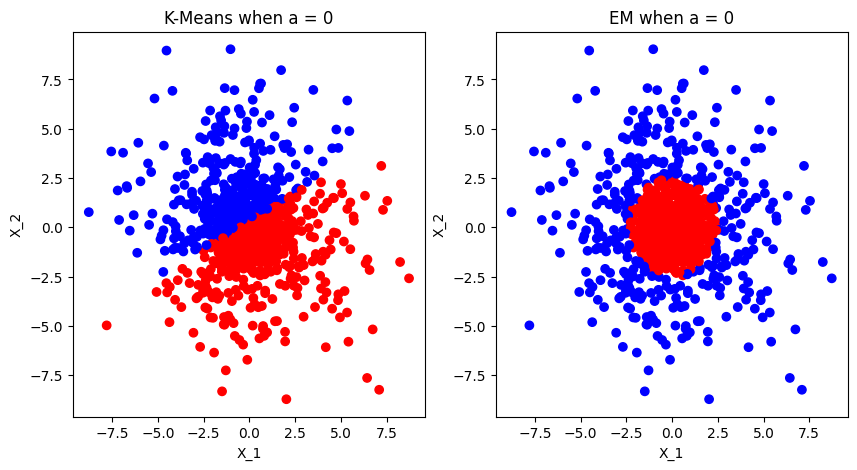

<Figure size 640x480 with 0 Axes>

In [25]:
## a)
X_Q = np.random.multivariate_normal([0, 0], 3**2 * np.eye(2), 500)
y_Q = np.zeros(500)
km_acc_result = np.zeros((5, 10))
km_ari_result = np.zeros((5, 10))
em_acc_result = np.zeros((5, 10))
em_ari_result = np.zeros((5, 10))

for a in [0, 1, 2, 3, 4]:
  X_a = np.random.multivariate_normal([a, 0], np.eye(2), 500)
  y_a = np.ones(500)
  X = np.vstack((X_Q, X_a))
  y = np.hstack((y_Q, y_a))

  for i in range(10):
    km = KMeans(n_clusters = 2, n_init = 1)
    y_km = km.fit_predict(X)

    em = GaussianMixture(n_components = 2)
    y_em = em.fit_predict(X)

    km_acc_result[a, i] = compute_accuracy(y, y_km)
    km_ari_result[a, i] = adjusted_rand_score(y, y_km)
    em_acc_result[a, i] = compute_accuracy(y, y_em)
    em_ari_result[a, i] = adjusted_rand_score(y, y_em)

    if a == 0 and i == 0:
      plt.figure(figsize = (10, 5))
      plt.subplot(1, 2, 1)
      plt.scatter(X[:, 0], X[:, 1], c = ['red' if x == 0 else 'blue' for x in y_km])
      # plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'black')
      plt.xlabel('X_1')
      plt.ylabel('X_2')
      plt.title(f'K-Means when a = {a}')

      plt.subplot(1, 2, 2)
      plt.scatter(X[:, 0], X[:, 1], c = ['red' if x == 0 else 'blue' for x in y_em])
      plt.xlabel('X_1')
      plt.ylabel('X_2')
      plt.title(f'EM when a = {a}')
      plt.show()

plt.tight_layout()

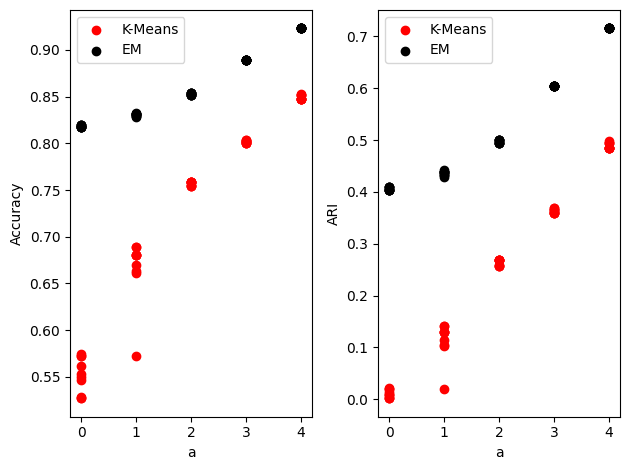

In [27]:
for a in [0, 1, 2, 3, 4]:
  plt.subplot(1, 2, 1)
  plt.scatter(np.repeat(a, 10), km_acc_result[a, :], color = 'red')
  plt.scatter(np.repeat(a, 10), em_acc_result[a, :], color = 'black')
  plt.legend(['K-Means', 'EM'])
  plt.xlabel('a')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.scatter(np.repeat(a, 10), km_ari_result[a, :], color = 'red')
  plt.scatter(np.repeat(a, 10), em_ari_result[a, :], color = 'black')
  plt.legend(['K-Means', 'EM'])
  plt.xlabel('a')
  plt.ylabel('ARI')

  plt.tight_layout()

In [4]:
def KMeans_Full(X, n_clusters = 2, max_iter = 100):
  ind = np.random.choice(len(X), n_clusters, replace = False)
  mus = X[ind]
  covs = [np.eye(X.shape[1]) for x in range(n_clusters)]

  for i in range(max_iter):
    prev_mus = mus.copy()
    label = []
    for x in X:
      dist = []
      for k, (mu, cov) in enumerate(zip(mus, covs)):
        dev = x - mu
        dist.append(dev @ np.linalg.inv(cov) @ dev.T)
      label.append(np.argmin(dist))

    label = np.array(label)
    mus = []
    covs = []
    for k in range(n_clusters):
      cluster = X[label == k]
      new_mu = np.mean(cluster, axis = 0)
      mus.append(new_mu)
      dev = cluster - new_mu
      covs.append(dev.T @ dev / (len(cluster) - 1))

    if np.all(np.linalg.norm(np.array(mus) - np.array(prev_mus)) < 1e-3):
      break

  return label

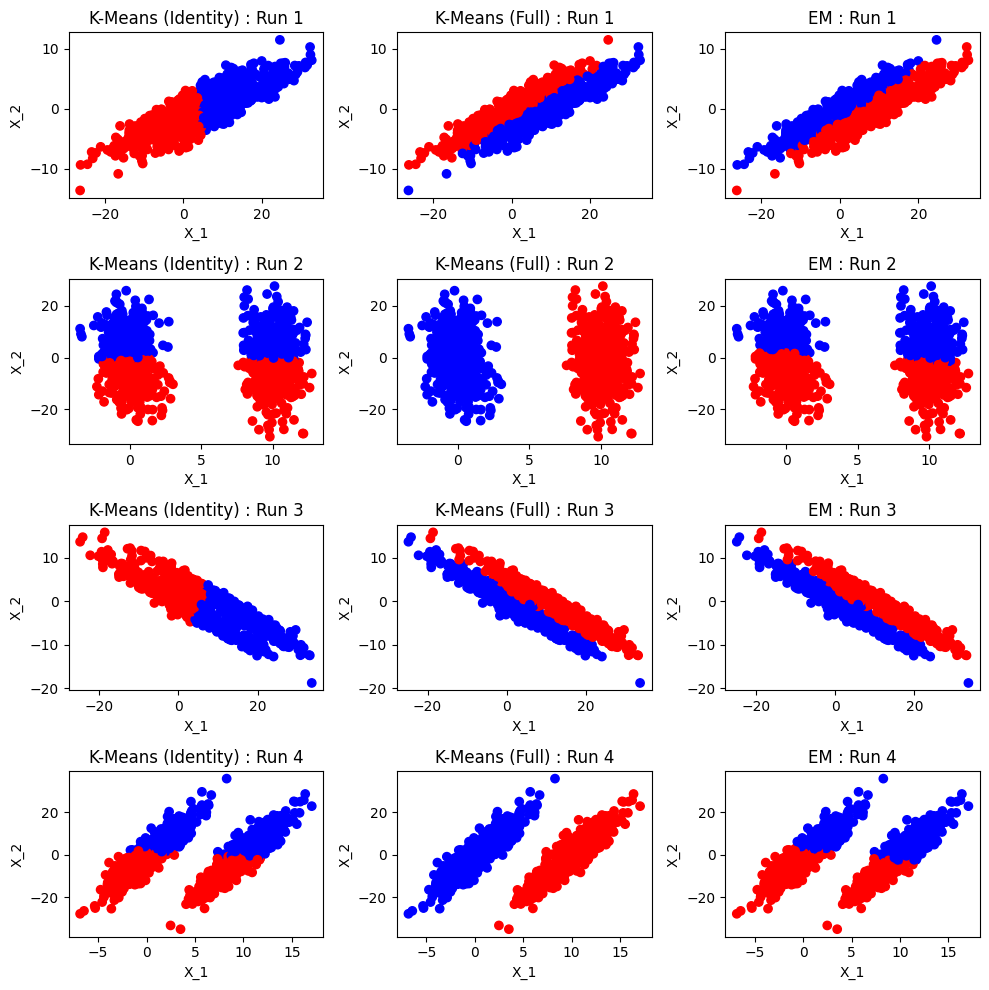

In [37]:
## b)
KLD_result = []
km_idt_acc = []
km_full_acc = []
em_acc = []
km_idt_ari = []
km_full_ari = []
em_ari = []
plt.figure(figsize = (10, 10))
for i in range(10):
  M = np.random.normal(0, 1, (2, 2))
  U, _, _ = np.linalg.svd(M)

  Sigma = U @ np.diag([100, 1]) @ U.T
  X_Q = np.random.multivariate_normal(np.array([0, 0]), Sigma, 500)
  X_P = np.random.multivariate_normal(np.array([10, 0]), Sigma, 500)
  X = np.vstack((X_Q, X_P))
  y = np.hstack((np.zeros(500), np.ones(500)))
  KLD_result.append(KLD(np.array([10, 0]), Sigma, np.array([0, 0]), Sigma))

  km_idt = KMeans(n_clusters = 2).fit_predict(X)
  km_full = KMeans_Full(X, n_clusters = 2)
  em = GaussianMixture(n_components = 2).fit_predict(X)

  km_idt_acc.append(compute_accuracy(y, km_idt))
  km_full_acc.append(compute_accuracy(y, km_full))
  em_acc.append(compute_accuracy(y, em))
  km_idt_ari.append(adjusted_rand_score(y, km_idt))
  km_full_ari.append(adjusted_rand_score(y, km_full))
  em_ari.append(adjusted_rand_score(y, em))

  if i < 4:
    plt.subplot(4, 3, 3 * i +1)
    plt.scatter(X[:, 0], X[:, 1], c = ['red' if x == 0 else 'blue' for x in km_idt])
    plt.title(f'K-Means (Identity) : Run {i + 1}')
    plt.xlabel('X_1')
    plt.ylabel('X_2')

    plt.subplot(4, 3, 3 * i + 2)
    plt.scatter(X[:, 0], X[:, 1], c = ['red' if x == 0 else 'blue' for x in km_full])
    plt.title(f'K-Means (Full) : Run {i + 1}')
    plt.xlabel('X_1')
    plt.ylabel('X_2')

    plt.subplot(4, 3, 3 * i + 3)
    plt.scatter(X[:, 0], X[:, 1], c = ['red' if x == 0 else 'blue' for x in em])
    plt.title(f'EM : Run {i + 1}')
    plt.xlabel('X_1')
    plt.ylabel('X_2')

plt.tight_layout()

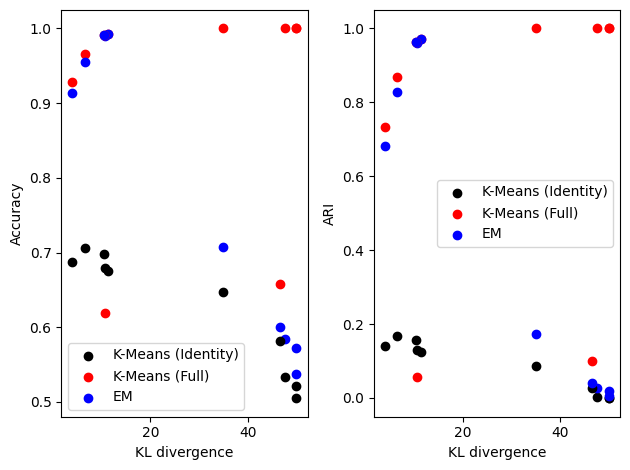

In [38]:
for a in range(10):
  plt.subplot(1, 2, 1)

  plt.scatter(KLD_result[a], km_idt_acc[a], color = 'black')
  plt.scatter(KLD_result[a], km_full_acc[a], color = 'red')
  plt.scatter(KLD_result[a], em_acc[a], color = 'blue')
  plt.legend(['K-Means (Identity)', 'K-Means (Full)', 'EM'])
  plt.xlabel('KL divergence')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.scatter(KLD_result[a], km_idt_ari[a], color = 'black')
  plt.scatter(KLD_result[a], km_full_ari[a], color = 'red')
  plt.scatter(KLD_result[a], em_ari[a], color = 'blue')
  plt.legend(['K-Means (Identity)', 'K-Means (Full)', 'EM'])
  plt.xlabel('KL divergence')
  plt.ylabel('ARI')

  plt.tight_layout()

In [39]:
print(pd.DataFrame({'Runs' : np.arange(1, 11), 'KL Divergence' : KLD_result, 'K-Means (Identity) Accuracy' : km_idt_acc, 'K-Means (Full) Accuracy' : km_full_acc, 'EM Accuracy' : em_acc, 'K-Means (Identity) ARI' : km_idt_ari, 'K-Means (Full) ARI' : km_full_ari, 'EM ARI' : em_ari}))

   Runs  KL Divergence  K-Means (Identity) Accuracy  K-Means (Full) Accuracy  \
0     1       6.561487                        0.706                    0.966   
1     2      49.988066                        0.521                    1.000   
2     3      11.388935                        0.676                    0.993   
3     4      47.601061                        0.533                    1.000   
4     5      46.628380                        0.582                    0.658   
5     6      10.606546                        0.680                    0.619   
6     7       4.023817                        0.688                    0.928   
7     8      49.937738                        0.505                    1.000   
8     9      35.005306                        0.647                    1.000   
9    10      10.429625                        0.698                    0.991   

   EM Accuracy  K-Means (Identity) ARI  K-Means (Full) ARI    EM ARI  
0        0.955                0.168916          